In [1]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
columns = ['Date', 'Position_x', 'Position_y', 'Position_z']
df = pd.DataFrame(columns=columns)

with open('RawData/horizons_results_30_years.csv') as f:
    f.readline()
    for line in f:
        line = line.strip().split(',')

        date = line[0]
        position = np.array(list(map(np.float128, line[1:4])))
        new_row = pd.DataFrame([[date, *position]], columns=columns)
        df = pd.concat([df, new_row], ignore_index=True)


/tmp/ipykernel_550477/3046378181.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [4]:
#crop df from datetime.datetime(2021, 7, 17, 0, 0) to datetime.datetime(2022, 2, 27, 0, 0)
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2021-07-17') & (df['Date'] < '2022-02-27')]
df = df.reset_index(drop=True)
df.head()

,Date,Position_x,Position_y,Position_z
0,2021-07-17,-1.066699e+08,-1.458516e+07,5.939509e+06
1,2021-07-18,-1.060891e+08,-1.755816e+07,5.854842e+06
2,2021-07-19,-1.054376e+08,-2.047769e+07,5.768427e+06
3,2021-07-20,-1.047254e+08,-2.334597e+07,5.681332e+06
4,2021-07-21,-1.039609e+08,-2.616742e+07,5.594390e+06


In [5]:
#sample the data into 80%
df_downsampled = df.iloc[::5, :]
df_downsampled = pd.concat([df_downsampled, df[-1:]], ignore_index=True)
df_downsampled = df_downsampled.reset_index(drop=True)
df_downsampled.head()

,Date,Position_x,Position_y,Position_z
0,2021-07-17,-1.066699e+08,-1.458516e+07,5.939509e+06
1,2021-07-22,-1.031507e+08,-2.894821e+07,5.508151e+06
2,2021-07-27,-9.848642e+07,-4.251244e+07,5.084802e+06
3,2021-08-01,-9.239514e+07,-5.601152e+07,4.600098e+06
4,2021-08-06,-8.393917e+07,-6.914554e+07,3.933959e+06


In [6]:
df_downsampled = df_downsampled.sort_values(by='Date')

time = (df_downsampled['Date'] - df['Date'].iloc[0]).dt.days.reset_index(drop=True).to_numpy()

In [7]:
def predictions(time, x_interpolator, y_interpolator, z_interpolator):
    x = x_interpolator(time)
    y = y_interpolator(time)
    z = z_interpolator(time)
    return np.array([x, y, z])

def plot_results(type, x_prediction, y_prediction, z_prediction, target_coordinates):
    plt.title(f'Using {type} interpolation')
    plt.plot(x_prediction, label='Predicted X')
    plt.plot(y_prediction, label='Predicted Y')
    plt.plot(z_prediction, label='Predicted Z')
    plt.plot(target_coordinates[:, 0], label='Target X')
    plt.plot(target_coordinates[:, 1], label='Target Y')
    plt.plot(target_coordinates[:, 2], label='Target Z')
    plt.legend()
    plt.show()

def plot_orbits(type, x_prediction, y_prediction, z_prediction, target_coordinates):
    fig = plt.figure()
    plt.title('Predicted Orbit using ' + type + ' interpolation')
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_prediction, y_prediction, z_prediction, label='Predicted Orbit')
    ax.plot(target_coordinates[:, 0], target_coordinates[:, 1], target_coordinates[:, 2], label='Target Orbit')
    plt.legend()
    plt.show()

In [8]:
print(len(time))
print(len(df_downsampled['Position_x']))

46
46


In [9]:
x_interpolator = interpolate.interp1d(time, df_downsampled['Position_x'], kind='cubic')
y_interpolator = interpolate.interp1d(time, df_downsampled['Position_y'], kind='cubic')
z_interpolator = interpolate.interp1d(time, df_downsampled['Position_z'], kind='cubic')

In [10]:
true_data = df[~df['Date'].isin(df_downsampled['Date'])][['Position_x', 'Position_y', 'Position_z']].values

In [11]:
prediction_time = df[~df['Date'].isin(df_downsampled['Date'])]['Date'] - df['Date'].iloc[0]
prediction_time = prediction_time.dt.days.reset_index(drop=True)

x_pred, y_pred, z_pred = predictions(prediction_time, x_interpolator, y_interpolator, z_interpolator)

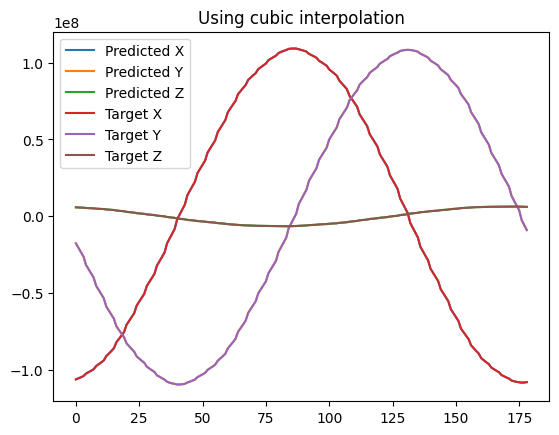

In [12]:
plot_results('cubic', x_pred, y_pred, z_pred, true_data)

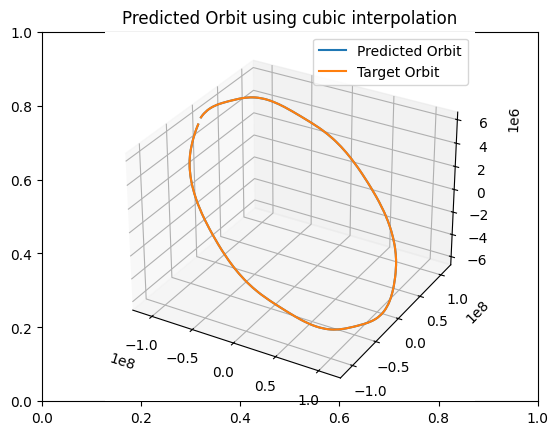

In [13]:
plot_orbits('cubic', x_pred, y_pred, z_pred, true_data)

Error Analysis

In [18]:
target_coordinates = np.array([x_pred, y_pred, z_pred]).T
pred_coordinates = true_data

In [21]:
#Error Analysis
diff = np.abs(target_coordinates - pred_coordinates)
max_error = np.max(diff, axis=0)
mean_error = np.mean(diff, axis=0)
std_error = np.std(diff, axis=0)

print(f'Max Error: {max_error} kms')
print(f'Mean Error: {mean_error} kms')
print(f'Std Error/Deviation: {std_error} kms')

Max Error: [42502.26992775 12726.27611686  5578.39538205] kms
Mean Error: [4099.67512066 3053.3898614   533.05678719] kms
Std Error/Deviation: [5399.68145104 2141.77786136  716.83800289] kms


In [22]:
# Calculate the error (Euclidean distance)
errors = np.sqrt(np.sum(diff**2, axis=1))

# Calculate the true values magnitude (norm)
true_magnitude = np.sqrt(np.sum(target_coordinates**2, axis=1))

# Calculate the relative error (percentage error)
error_percentage = np.max(errors / true_magnitude) * 100

print(f"Final Error Percentage: {error_percentage:.2f}%")

Final Error Percentage: 0.04%


In [23]:
mean_squared_error = np.mean(np.sum(diff**2, axis=1))
root_mean_squared_error = np.sqrt(mean_squared_error)
mean_absolute_error = np.mean(np.sum(diff, axis=1))

print(f'Mean Squared Error: {mean_squared_error} kms^2')
print(f'Root Mean Squared Error: {root_mean_squared_error} kms')
print(f'Mean Absolute Error: {mean_absolute_error} kms')

Mean Squared Error: 60672304.18146398 kms^2
Root Mean Squared Error: 7789.242850333015 kms
Mean Absolute Error: 7686.121769246517 kms


In [24]:
#Axis-wise Error Analysis
diff_x = np.abs(target_coordinates[:, 0] - pred_coordinates[:, 0])
diff_y = np.abs(target_coordinates[:, 1] - pred_coordinates[:, 1])
diff_z = np.abs(target_coordinates[:, 2] - pred_coordinates[:, 2])

max_error_x = np.max(diff_x)
mean_error_x = np.mean(diff_x)
std_error_x = np.std(diff_x)

max_error_y = np.max(diff_y)
mean_error_y = np.mean(diff_y)
std_error_y = np.std(diff_y)

max_error_z = np.max(diff_z)
mean_error_z = np.mean(diff_z)
std_error_z = np.std(diff_z)

mean_squared_error_x = np.mean(diff_x**2)
mean_squared_error_y = np.mean(diff_y**2)
mean_squared_error_z = np.mean(diff_z**2)

root_mean_squared_error_x = np.sqrt(mean_squared_error_x)
root_mean_squared_error_y = np.sqrt(mean_squared_error_y)
root_mean_squared_error_z = np.sqrt(mean_squared_error_z)

mean_absolute_error_x = np.mean(diff_x)
mean_absolute_error_y = np.mean(diff_y)
mean_absolute_error_z = np.mean(diff_z)

print(f'X-Axis Error Analysis')
print(f'Max Error: {max_error_x} kms')
print(f'Mean Error: {mean_error_x} kms')
print(f'Std Error/Deviation: {std_error_x} kms')
print(f'Mean Squared Error: {mean_squared_error_x} kms^2')
print(f'Root Mean Squared Error: {root_mean_squared_error_x} kms')
print(f'Mean Absolute Error: {mean_absolute_error_x} kms')

print(f'\nY-Axis Error Analysis')
print(f'Max Error: {max_error_y} kms')
print(f'Mean Error: {mean_error_y} kms')
print(f'Std Error/Deviation: {std_error_y} kms')
print(f'Mean Squared Error: {mean_squared_error_y} kms^2')
print(f'Root Mean Squared Error: {root_mean_squared_error_y} kms')
print(f'Mean Absolute Error: {mean_absolute_error_y} kms')

print(f'\nZ-Axis Error Analysis')
print(f'Max Error: {max_error_z} kms')
print(f'Mean Error: {mean_error_z} kms')
print(f'Std Error/Deviation: {std_error_z} kms')
print(f'Mean Squared Error: {mean_squared_error_z} kms^2')
print(f'Root Mean Squared Error: {root_mean_squared_error_z} kms')
print(f'Mean Absolute Error: {mean_absolute_error_z} kms')

X-Axis Error Analysis
Max Error: 42502.269927755 kms
Mean Error: 4099.6751206590325 kms
Std Error/Deviation: 5399.681451035285 kms
Mean Squared Error: 45963895.86760517 kms^2
Root Mean Squared Error: 6779.667828707035 kms
Mean Absolute Error: 4099.6751206590325 kms

Y-Axis Error Analysis
Max Error: 12726.276116863824 kms
Mean Error: 3053.3898614007007 kms
Std Error/Deviation: 2141.7778613575283 kms
Mean Squared Error: 13910402.05310582 kms^2
Root Mean Squared Error: 3729.66513954079 kms
Mean Absolute Error: 3053.3898614007007 kms

Z-Axis Error Analysis
Max Error: 5578.395382045768 kms
Mean Error: 533.0567871867844 kms
Std Error/Deviation: 716.838002889842 kms
Mean Squared Error: 798006.2607529939 kms^2
Root Mean Squared Error: 893.3119616085938 kms
Mean Absolute Error: 533.0567871867844 kms


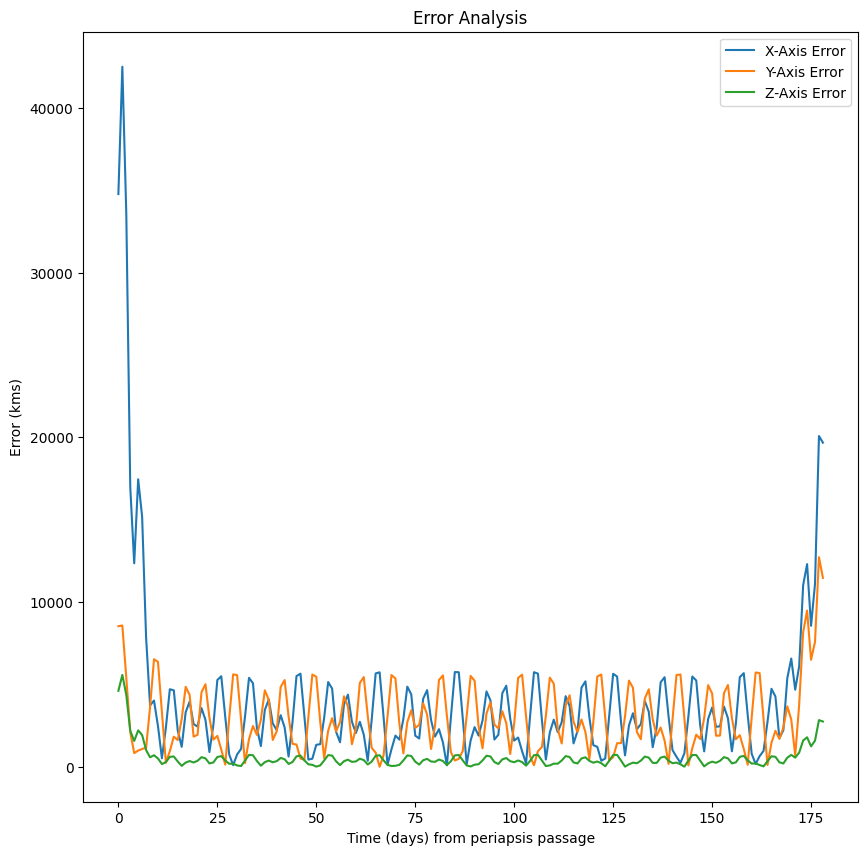

In [25]:
#Error Visualization
plt.figure(figsize=(10, 10))
plt.plot(diff_x, label='X-Axis Error')
plt.plot(diff_y, label='Y-Axis Error')
plt.plot(diff_z, label='Z-Axis Error')
plt.title('Error Analysis')
plt.xlabel('Time (days) from periapsis passage')
plt.ylabel('Error (kms)')
plt.legend()
plt.show()